# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['figure.figsize'] = (10,5)

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [8]:
tracks = pd.read_parquet("./datasets/tracks.parquet")

In [9]:
catalog_names = pd.read_parquet("./datasets/catalog_names.parquet")

In [10]:
interactions = pd.read_parquet("./datasets/interactions.parquet")

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [6]:
# функция для знакомства с данными
def df_info(df):
    display("Фрагмент датасета")
    display(df.sample(5))
    display("-------------------------")
    display("Проверяем на наличие пропущенных значение")
    display(df.isna().sum())
    display("-------------------------")
    display("Информация о датасете")
    display(df.info())
    display("-------------------------")
    display("Размерность")
    display(df.shape)

In [11]:
df_info(tracks)

'Фрагмент датасета'

,track_id,albums,artists,genres
795903,62161836,"[9770137, 9770172, 9772480, 9774345, 9776369]",[29063],"[14, 102]"
907042,76669103,"[13544471, 16291406]",[7013449],[11]
899035,75020911,[13149771],[593930],[25]
544460,37629201,[4620193],"[2922297, 3444221, 5117765]","[3, 75]"
335967,21781682,"[2501206, 2528360, 2538175, 2553777, 2659183, ...","[457446, 1433418]",[11]


'-------------------------'

'Проверяем на наличие пропущенных значение'

track_id    0
albums      0
artists     0
genres      0
dtype: int64

'-------------------------'

'Информация о датасете'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


None

'-------------------------'

'Размерность'

(1000000, 4)

С виду явных проблем нет, идентификаторы менять не стоит. Но видно что данные в столбцах кроме track_id содержат массивы, очевидно что пустой массив это не пропущенное значение, хотя данных не содержит. Проведу проверку.

In [12]:
# функция для поиска пустых массивов.
def missed_value(df, column):
    df_missed_value =df[df[column].apply(lambda x: len(x) == 0)]
    return df_missed_value

In [13]:
missed_value(tracks, 'artists')

,track_id,albums,artists,genres
146031,3599314,[389925],[],"[68, 86]"
146163,3599591,[389944],[],"[68, 86]"
177544,4790215,[533785],[],"[68, 86]"
218922,10063296,[1083742],[],"[11, 20]"
231455,12122918,[1315834],[],[68]
...,...,...,...,...
999868,101201589,[12649219],[],"[62, 77]"
999876,101219571,[9444321],[],"[62, 83, 77]"
999901,101243616,[11700332],[],"[62, 93]"
999920,101292599,[9331881],[],"[62, 90, 77, 84]"


In [14]:
missed_value(tracks, 'albums')

,track_id,albums,artists,genres
310821,20200372,[],[],[]
310826,20200380,[],[],[]
312469,20305116,[],[],[]
312474,20305121,[],[],[]
320353,20756854,[],[],[]
326588,21196099,[],[],[]
326592,21196103,[],[],[]
326594,21196105,[],[],[]
326596,21196107,[],[],[]
326598,21196109,[],[],[]


In [15]:
missed_value(tracks, 'genres')

,track_id,albums,artists,genres
490,2520,"[249, 163801, 163802, 324616, 17542430, 189498...",[2259],[]
3069,16776,"[1479, 5319, 6093, 8467, 10641, 90867, 163801,...",[978],[]
3077,16801,"[1479, 163801, 9287549, 9377183, 9424994, 1201...",[10520],[]
4192,23752,"[2001, 3722, 4973, 6104, 6558, 23866, 37052, 7...",[13373],[]
6645,38012,"[3147, 60099, 530836, 1115289, 2490724, 818446...",[16758],[]
...,...,...,...,...
997667,99412992,[20764551],[10029101],[]
999192,100497082,[21098340],[15936615],[]
999703,100923319,[21233460],[5271861],[]
999704,100923322,[21233460],[5271861],[]


В датафрейме есть строки с неизвестными исполнителями, альбомами и жанрами. Для принятия решения что делать с этими строками изучу какой процент от общих они составляют.

In [17]:
missing_values = tracks[
    (tracks['artists'].str.len() == 0) | (tracks['albums'].str.len() == 0) | (tracks['genres'].str.len() == 0)]

In [18]:
percent_missing_values = len(missing_values) / len(tracks) * 100
print(f"Процент данных в missing_values от общего количества данных в tracks: {percent_missing_values:.1f}%")

Процент данных в missing_values от общего количества данных в tracks: 1.9%


Менее 3%, считаю что могу их просто удалить.

In [19]:
indexes_to_drop = missing_values.index

In [20]:
tracks = tracks.drop(indexes_to_drop).reset_index(drop=True)

In [21]:
missed_value(tracks, 'albums')

,track_id,albums,artists,genres


In [22]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980977 entries, 0 to 980976
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   track_id  980977 non-null  int64 
 1   albums    980977 non-null  object
 2   artists   980977 non-null  object
 3   genres    980977 non-null  object
dtypes: int64(1), object(3)
memory usage: 29.9+ MB


Принимаю решение заменить нормализовать идентификаторы.

In [23]:
tracks = tracks.explode('albums').explode('artists').explode('genres')

In [27]:
tracks.sample(6)

,track_id,albums,artists,genres
12703,75774,4501362,320,68
573718,39649659,5121344,5709190,75
309776,20216918,2290572,1443757,25
923,4185,10066186,1438,11
633017,44310825,6826277,249690,68
136281,2714991,14795566,4607579,11


In [28]:
tracks[['albums', 'artists', 'genres']] = tracks[['albums', 'artists', 'genres']].apply(lambda x: x.astype('int'))

In [30]:
#tracks.info()

In [31]:
# уборочка
del tracks

In [11]:
df_info(catalog_names)

'Фрагмент датасета'

,id,type,name
1012615,7200773,track,Medieval
8647,24798,album,Close To Seven
366025,6304376,album,Silence
1226613,28422300,track,Радуйся
832775,116473,track,Джанкойский этап


'-------------------------'

'Проверяем на наличие пропущенных значение'

id      0
type    0
name    0
dtype: int64

'-------------------------'

'Информация о датасете'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


None

'-------------------------'

'Размерность'

(1812471, 3)

В целом данные выглядят прилично, пропусков нет, типы данных соответсвуют. Если нет дубликатов, полагаю можно оставить как есть.

In [16]:
# проверю неявные дубликаты в колонуе с типом
print(catalog_names['type'].unique())

['album' 'artist' 'genre' 'track']


In [34]:
# дубликаты по связке имя-тип
len(catalog_names[(catalog_names.duplicated(['id','type']) == True)])

0

In [12]:
# дубликаты по связке тип и наименование
len(catalog_names[(catalog_names.duplicated(['type','name']) == True)])

689769

In [22]:
# группировка по 'type' и 'name', а затем отбор групп, где количество записей больше 1
duplicate_counts = (catalog_names
                    .groupby(['type', 'name'])
                    .filter(lambda x: len(x) > 1)
                    .groupby(['type', 'name'])
                    .size())

# преобразование Series в DataFrame для удобства чтения
duplicate_counts_df = duplicate_counts.reset_index(name='duplicate_count')

# Количество дубликатов по связке 'type' и 'name'
print(duplicate_counts_df.sample(5))

         type             name  duplicate_count
109211  track    Halcyon Birds                2
115131  track  In Between Days                6
38913   album    Music Is Life                2
89153   track    Be Aggressive                2
187179  track    Песня о Волге                2


In [25]:
counts = duplicate_counts_df.groupby('type')['duplicate_count'].sum()

# Достаем количество дубликатов для 'album' и 'track'
album_duplicates_count = counts.get('album', 0)
track_duplicates_count = counts.get('track', 0)

# Вывод результата
print(f"Количество дубликатов для album: {album_duplicates_count}")
print(f"Количество дубликатов для track: {track_duplicates_count}")

Количество дубликатов для album: 298518
Количество дубликатов для track: 590064


In [26]:
# уборочка
del duplicate_counts
del duplicate_counts_df
del counts
del album_duplicates_count
del track_duplicates_count

Тут не все радужно, задублированных значений по связке тип и наименование всего 689769. Оценочно это порядка 38% данных. Причина появления дубликатов не известна, не похоже на ошибку сбора информации. Полагаю удалять не следует.

In [35]:
del catalog_names

In [22]:
df_info(interactions)

'Фрагмент датасета'

,user_id,track_id,track_seq,started_at
216,1221651,70471517,217,2022-11-16
4,837537,439925,5,2022-07-16
181,798669,51452575,182,2022-10-19
40,1077074,417949,41,2022-03-31
145,111758,22425013,146,2022-08-16


'-------------------------'

'Проверяем на наличие пропущенных значение'

user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64

'-------------------------'

'Информация о датасете'

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


None

'-------------------------'

'Размерность'

(222629898, 4)

In [39]:
len(interactions[(interactions.duplicated(['user_id','track_id']) == True)])

0

# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

In [7]:
interactions.sample(3).T

,43,58,96
user_id,236523,267031,1088725
track_id,24814073,45902098,58085423
track_seq,44,59,97
started_at,2022-11-29 00:00:00,2022-03-15 00:00:00,2022-07-13 00:00:00


In [8]:
interactions.describe(include='all')

,user_id,track_id,track_seq,started_at
count,2.226299e+08,2.226299e+08,2.226299e+08,222629898
mean,6.875767e+05,3.653622e+07,4.621403e+02,2022-08-29 16:39:44.541336320
min,0.000000e+00,2.600000e+01,1.000000e+00,2022-01-01 00:00:00
25%,3.433710e+05,1.480849e+07,5.600000e+01,2022-07-02 00:00:00
50%,6.879730e+05,3.552474e+07,1.810000e+02,2022-09-15 00:00:00
75%,1.031127e+06,5.651137e+07,5.060000e+02,2022-11-09 00:00:00
max,1.374582e+06,1.015218e+08,1.663700e+04,2022-12-31 00:00:00
std,3.969033e+05,2.661782e+07,8.257312e+02,NaN


In [ ]:
Доля пользователей приходящихся на один трек

In [13]:
n_users = interactions['user_id'].nunique()
n_users

1373221

In [14]:
user_share_per_track = (
    (interactions.groupby('track_id').agg(user_share=('user_id', 'nunique')) / n_users * 100)
    .reset_index()
)

In [16]:
user_share_per_track.describe()

,track_id,user_share
count,1.000000e+06,1000000.000000
mean,3.685121e+07,0.016212
std,2.679771e+07,0.099760
min,2.600000e+01,0.000364
25%,1.543088e+07,0.000655
50%,3.455047e+07,0.001384
75%,5.692557e+07,0.004879
max,1.015218e+08,8.087700


Распределение прослушанных треков на пользователя

In [31]:
len(interactions['track_id'])/n_users

162.12241001266366

Распределение количества прослушанных треков, как часто прослушивают тот или иной трек.

In [33]:
track_counts = interactions['track_id'].value_counts().reset_index()
track_counts.columns = ['track_id', 'listen_count']

In [28]:
track_counts.describe()

,track_id,listen_count
count,1.000000e+06,1000000.000000
mean,3.685121e+07,222.629898
std,2.679771e+07,1369.930708
min,2.600000e+01,5.000000
25%,1.543088e+07,9.000000
50%,3.455047e+07,19.000000
75%,5.692557e+07,67.000000
max,1.015218e+08,111062.000000


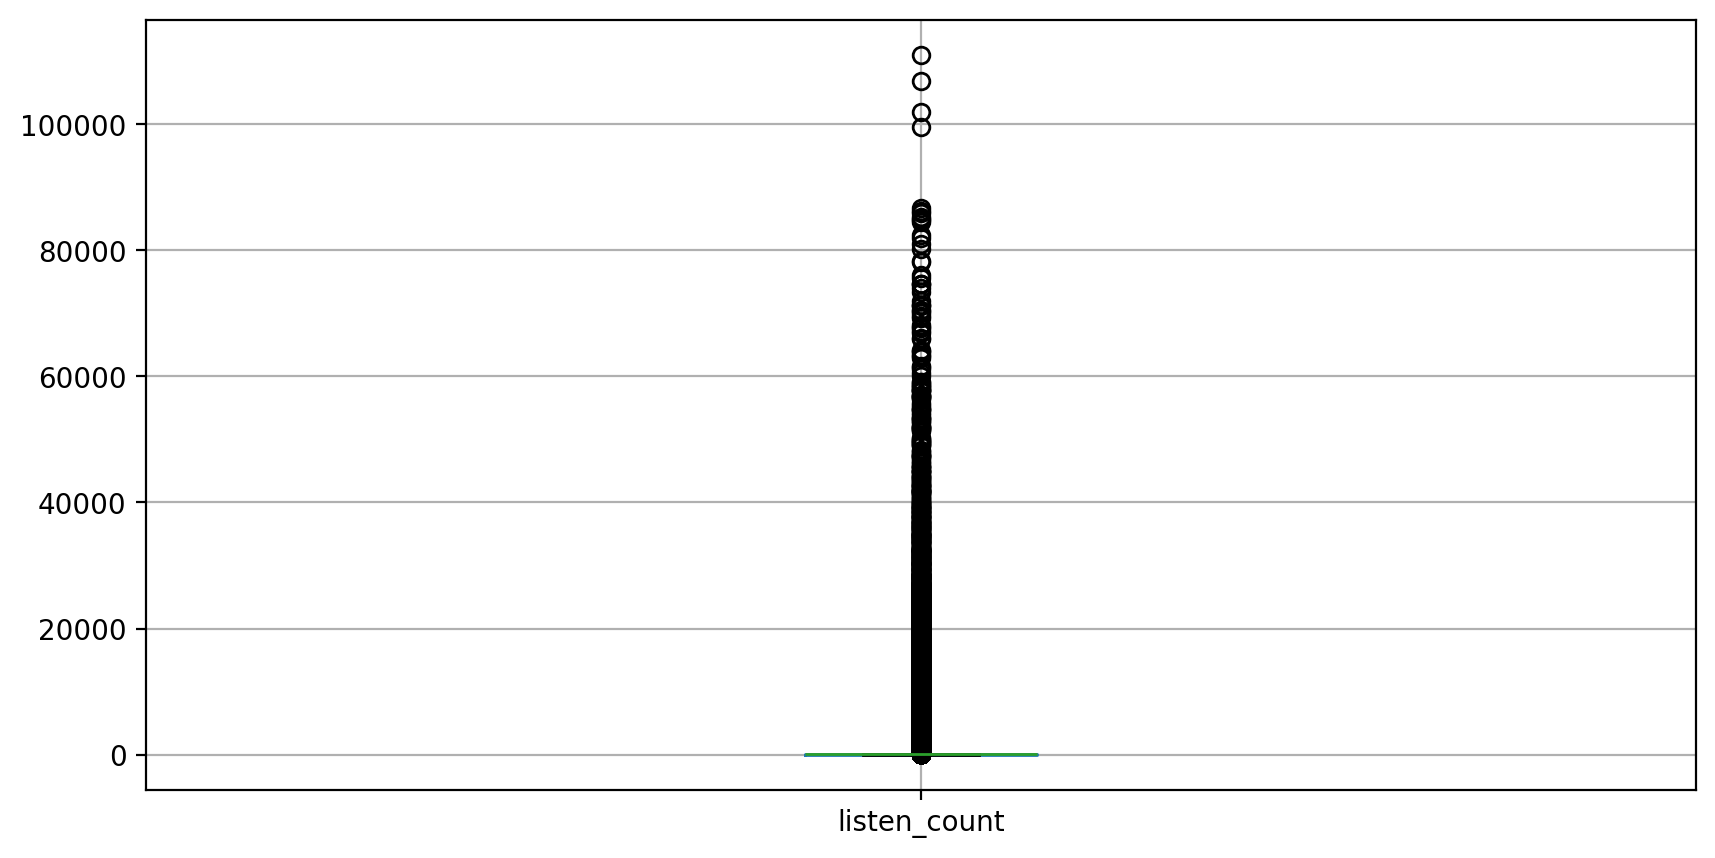

In [29]:
track_counts.boxplot(column = 'listen_count');

Text(0, 0.5, 'Количество')

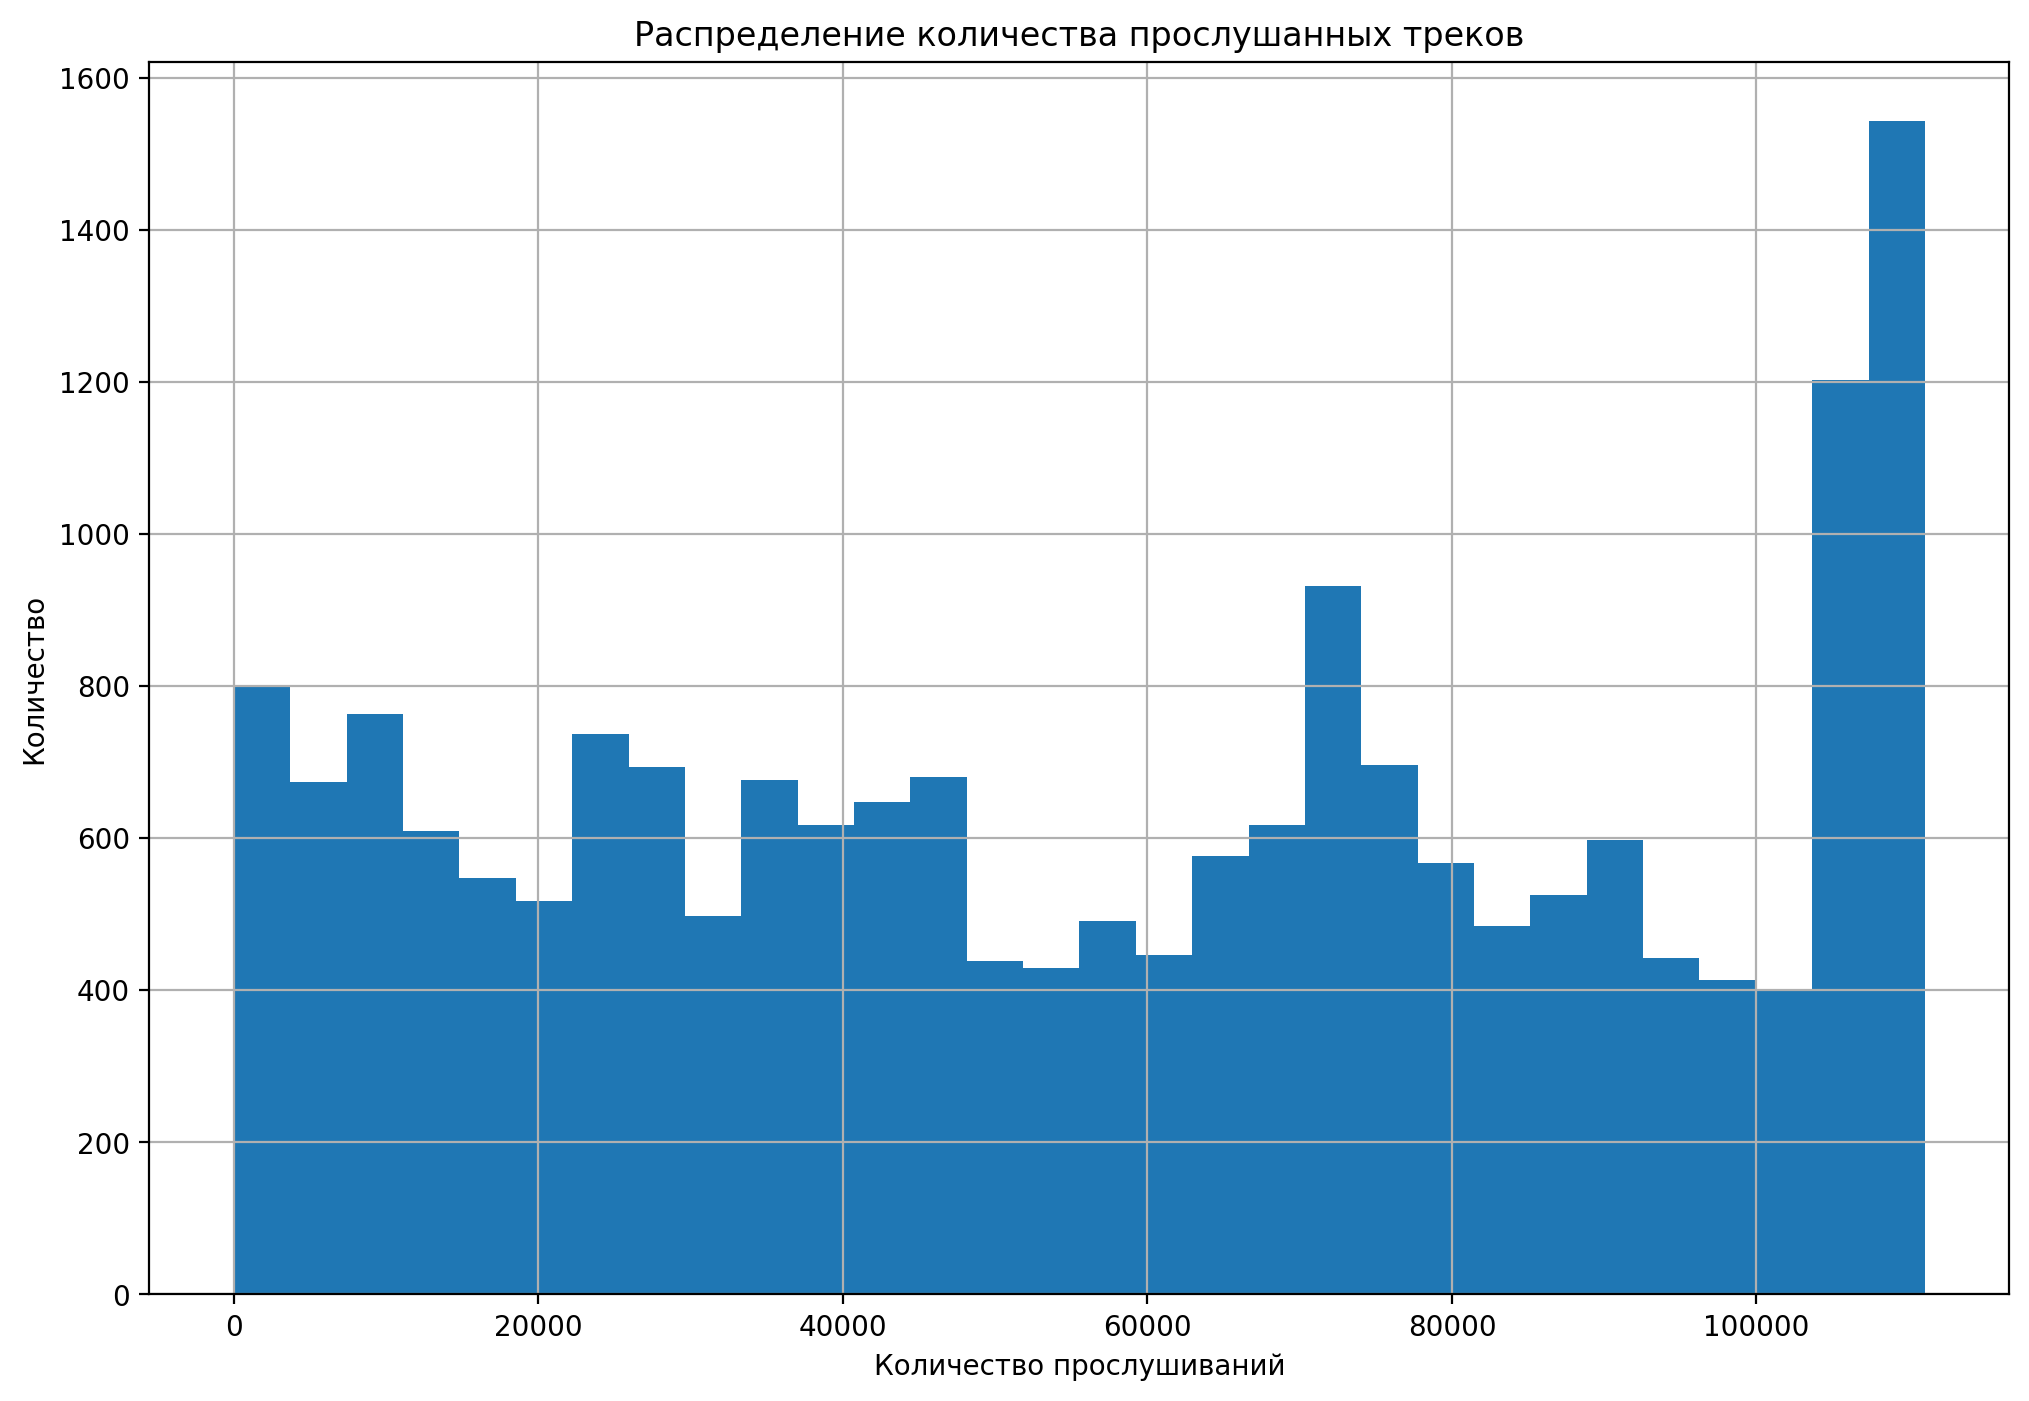

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = track_counts['track_id'].plot(kind='hist', bins=30, range=(5,111062), title='Распределение количества прослушанных треков', grid=True)
ax.set_xlabel('Количество прослушиваний')
ax.set_ylabel('Количество')

In [25]:
track_to_plot_track_counts = track_counts.head(30)

In [ ]:
sorted_tracks = track_counts.sort_values(by='listen_count', ascending=False)

In [27]:
# оценка взаимодействия пользователей с трекаками
print(interactions[["user_id", "track_id", "track_seq", "started_at"]].sample(5).sort_values("user_id").set_index(["user_id", "track_id"]))

                  track_seq started_at
user_id track_id                      
369734  79184551       1115 2022-11-21
626108  19622237        290 2022-07-30
728843  795836          129 2022-07-04
1089924 77296031        167 2022-09-29
1279900 33355173         39 2022-06-10


Наиболее популярные треки

Наиболее популярные жанры

Треки, которые никто не прослушал

# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

# Топ популярных

Рассчитаем рекомендации как топ популярных.

# Персональные

Рассчитаем персональные рекомендации.

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.